# Creating a Molecule's Potential Energy Curve

A potential energy curve gives the ground energy of an assemble of atoms as function of the distances between them. The global minima of the curve indicates the binding energy and internuclear distance for the stable molecule. Therefor, such curve can be powerful tool in computational chemistry, for predicting molecular structure and spectrum.

In this tutorial, we will demonstrate how, using Classiq's VQE package, the user can create a Molecule's potential energy curve, and compare the result those of the Hartree-Fock approximative method and to the exact results. The exact solution is a result of diagonalizing the Hamiltonian.

## 0. Pre-requirments

The model is using several Classiq's libraries in addition to IBM's simulating tool.

In [6]:
import time

import matplotlib.pyplot as plt
import numpy as np

from classiq import *
from classiq.applications.chemistry import (
    ChemistryExecutionParameters,
    HEAParameters,
    Molecule,
    MoleculeProblem,
    UCCParameters,
)
from classiq.execution import OptimizerType

## 1. Defintions and Initialization

Here, we define the range of internuclear distances for the model to simulate, and chose the number of sampling point in this range, which determines the graph's resolution.

In [7]:
# define the sampling params
num1 = 5  # how many sampling points - determines your resolution
start1 = 0.20  # what is your sampling start distance
stop1 = 1  # what is your sampling end distance
num2 = 7  # how many sampling points - determines your resolution
start2 = 1.4  # what is your sampling start distance
stop2 = 3.5  # what is your sampling end distance


# prepare x,y vectors
distance = np.append(np.linspace(start1, stop1, num1), np.linspace(start2, stop2, num2))
VQE_energy = []
HF_energy = []
exact_energy = []

print(distance)

[0.2  0.4  0.6  0.8  1.   1.4  1.75 2.1  2.45 2.8  3.15 3.5 ]


## 2. Energy Estimations

Here we define a for-loop, which does the following steps:

a. creating molecule at changing distances between the atoms.

b. Constructing a chemistry model for the corresponding Hamiltonian, using Hartree-Fock initial state and UCC ansatz.

c. Synthesizing the model to get a quantum program.

d. Executing the quantum program to extract a solution for the ground energy.

e. Obtain the exact solution and Hartree-Fock solution.

In [8]:
# create the molecule, insert the distance, prepare H, create UCC anzats and solve in energy

qmods = []
qprogs = []
results = []
durations = []

for x in distance:
    time1 = time.time()

    molecule = Molecule(atoms=[("H", (0.0, 0.0, 0)), ("H", (0.0, 0.0, float(x)))])

    chemistry_problem = MoleculeProblem(
        molecule=molecule,
        mapping="jordan_wigner",  # 'bravyi_kitaev'
        z2_symmetries=True,
        freeze_core=True,
    )

    qmod = construct_chemistry_model(
        chemistry_problem=chemistry_problem,
        use_hartree_fock=True,
        ansatz_parameters=UCCParameters(excitations=[1, 2]),
        execution_parameters=ChemistryExecutionParameters(
            optimizer=OptimizerType.COBYLA,
            max_iteration=30,
            initial_point=None,
        ),
    )
    qmods.append(qmod)

    qprog = synthesize(qmod)
    qprogs.append(qprog)

    result = execute(qprog).result()
    results.append(result)
    chemistry_result_dict = result[1].value

    operator = chemistry_problem.generate_hamiltonian()
    mat = operator.to_matrix()
    w, v = np.linalg.eig(mat)
    result_exact = np.real(min(w)) + chemistry_result_dict["nuclear_repulsion_energy"]

    VQE_energy.append(chemistry_result_dict["total_energy"])

    HF_energy.append(chemistry_result_dict["hartree_fock_energy"])

    exact_energy.append(result_exact)

    time2 = time.time()
    duration = time2 - time1
    durations.append(duration)
    print(duration)

11.206981897354126
11.011789798736572
9.279333591461182
10.444861650466919
10.7950279712677
11.063537836074829
9.81880521774292
9.367217063903809


ClassiqAPIError: Call to API failed with code 400: Apologies for the inconvenience. We're currently experiencing an overwhelming surge in user activity, causing our system to be temporarily overloaded. Our team is actively addressing this and working on resolving the issue to provide you with a smoother experience. Please bear with us as we work to accommodate the high interest and requests. Thank you for your patience.

Error identifier: E95E27CA4-B0B5-42C1-9891-25DB1F1285D7.
If you need further assistance, please reach out on our Community Slack channel at: https://short.classiq.io/join-slack or open a support ticket at: https://classiq-community.freshdesk.com/support/tickets/new

In [ ]:
# save the last model to a qmod file
write_qmod(qmods[-1], "molecular_energy_curve")

## 3. Create Graph

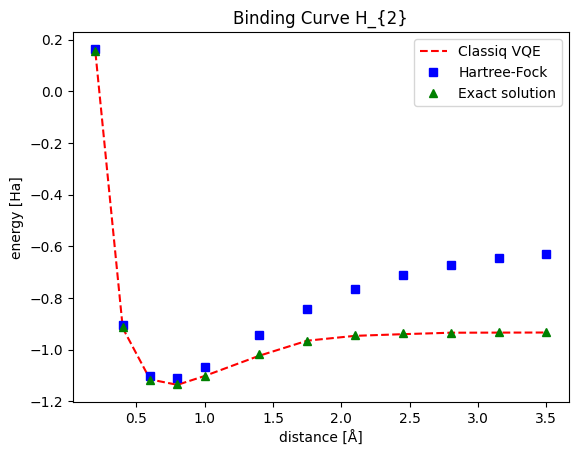

In [ ]:
plt.plot(
    distance, VQE_energy, "r--", distance, HF_energy, "bs", distance, exact_energy, "g^"
)

plt.xlabel("distance [Å]")
plt.ylabel("energy [Ha]")
plt.legend(["Classiq VQE", "Hartree-Fock", "Exact solution"])
plt.title("Binding Curve H_{2}")

plt.show()

This graph presents the ground state for $H_{2}$ molecule as a function of the distance between the two hydrogen atoms. One can see that both the HF solution and Classiq VQE present decent results around the global minima. For further distances, Classiq VQE stays close to the exact solution while the HF solution gradually deviates. The source of this lack of correspondence is with the lack of flexible correlations within the HF model, which is enabled within VQE scope.
One can similarly create graphs for different molecules (even n- dimensional or larger atom assemblies), to explore more curves.


# 4. Define Adapt_VQE using Flexible QPE

In [11]:
## Imports

import matplotlib.pyplot as plt
import numpy as np

from classiq import *

# for chemistry
from classiq.applications.chemistry import Molecule, MoleculeProblem
from classiq.applications.combinatorial_helpers.pauli_helpers.pauli_utils import (
    pauli_operator_to_hamiltonian,
)

#Flexible QPE

@qfunc
def my_qpe_flexible(
    unitary: QCallable[CInt, QArray[QBit]],
    state: QArray[QBit],
    phase: QArray[QBit],
) -> None:
    apply_to_all(H, phase)

    repeat(
        count=phase.len,
        iteration=lambda index: control(
            ctrl=phase[index],
            stmt_block=lambda: unitary(2**index, state),
        ),
    )

    invert(
        lambda: qft(phase),
    )

### Define a molecule with Classiq

I choose to work on the LiH molecule:

In [20]:
# build your molecule


molecule_LiH = Molecule(atoms=[("H", (0.0, 0.0, 0.0)), ("Li", (0.0, 0.0, 1.596))])

# Example of some other molecules:
molecule_H2 = Molecule(atoms=[("H", (0.0, 0.0, 0)), ("H", (0.0, 0.0, 0.735))])
molecule_O2 = Molecule(atoms=[("O", (0.0, 0.0, 0)), ("O", (0.0, 0.0, 1.16))])
molecule_H2O = Molecule(
    atoms=[("O", (0.0, 0.0, 0.0)), ("H", (0, 0.586, 0.757)), ("H", (0, 0.586, -0.757))]
)
molecule_BeH2 = Molecule(
    atoms=[("Be", (0.0, 0.0, 0.0)), ("H", (0, 0, 1.334)), ("H", (0, 0, -1.334))]
)

molecule = molecule_LiH

In [21]:
# define your molecule problem

gs_problem = MoleculeProblem(
    molecule=molecule,
    basis="sto3g",
    mapping="jordan_wigner",  #'bravyi_kitaev'
    z2_symmetries=True,
    freeze_core=True,
)

operator = gs_problem.generate_hamiltonian()
gs_problem = gs_problem.update_problem(operator.num_qubits)

mol_hamiltonian = pauli_operator_to_hamiltonian(operator.pauli_list)
problem_size = len(mol_hamiltonian[0].pauli)

print(
    f"The Hamiltonian is defined on {problem_size} qubits, and contains {len(mol_hamiltonian)} Pauli strings"
)

The Hamiltonian is defined on 6 qubits, and contains 231 Pauli strings


Finally, we calculate the ground state energy as a reference solution to our quantum solver (note that the Hamiltonian obtained from the Molecule object excludes the nuclear repulsion energy).

In [22]:
mat = hamiltonian_to_matrix(mol_hamiltonian)
w, v = np.linalg.eig(mat)
classical_sol = np.real(min(w))
print(f"Expected energy (without nuclear repulsion energy): {classical_sol} Ha")

Expected energy (without nuclear repulsion energy): -1.0789776863285285 Ha


### Preparing the Molecule for QPE
#### Trimming the Hamiltonian
As we can see, the Hamiltonian may contain a large number of terms. In many cases we can compress the Hamiltonian by trimming small terms.

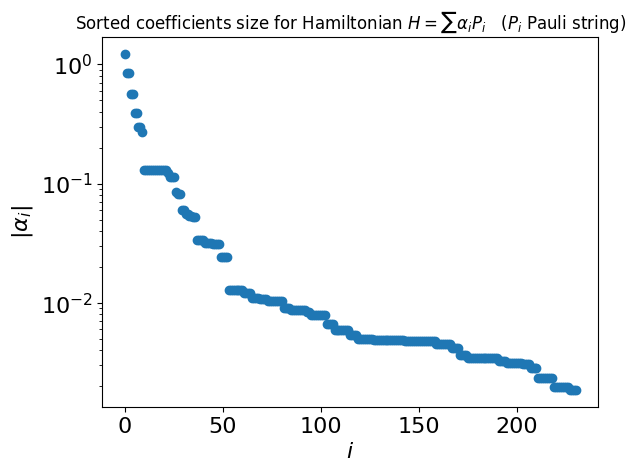

In [23]:
coeffs = [term.coefficient for term in mol_hamiltonian]
plt.semilogy(np.sort(np.abs(coeffs))[::-1], "o")
plt.ylabel(r"$|\alpha_i|$", fontsize=16)
plt.xlabel(r"$i$", fontsize=16)
plt.tick_params(axis="both", labelsize=16)
plt.title(
    r"Sorted coefficients size for Hamiltonian $H = \sum \alpha_i P_i$   ($P_i$ Pauli string)"
);

We define some threshold and trim the Hamiltonian accordingly:

In [24]:
def trim_hamiltonian(hamiltonian, threshold):
    return [
        PauliTerm(pauli=term.pauli, coefficient=term.coefficient)
        for term in hamiltonian
        if np.abs(term.coefficient) > threshold
    ]

In [25]:
THRESHOLD = 0.03

trimmed_mol_hamiltonian = trim_hamiltonian(mol_hamiltonian, THRESHOLD)
print(f"Length of trimmed Hamiltonian: {len(trimmed_mol_hamiltonian)}")

Length of trimmed Hamiltonian: 49


### Normalizing the Hamiltonian for QPE

Since we are working with QPE, the ground state energy is inferred as a phase, thus, we shall normalize the Hamiltonian such that its eigenvalues are in $\left[-\frac{1}{2},\frac{1}{2}\right)$. This is done by finding a bound on the maximal absolute value of eigenvalues $\tilde{\lambda}_{\max}$, and normalizing the Hamiltonian by $2\tilde{\lambda}_{\max}$. A simple bound is given by the sum of Pauli coefficients of the Hamiltonian.

In [26]:
def normalize_hamiltonian(hamiltonian):
    approx_lambda_max = sum(np.abs(term.coefficient) for term in hamiltonian)
    normalization = 2 * approx_lambda_max
    normalized_mol_hamiltonian = [
        PauliTerm(pauli=term.pauli, coefficient=term.coefficient / (normalization))
        for term in hamiltonian
    ]

    return normalization, normalized_mol_hamiltonian


normalization, normalized_mol_hamiltonian = normalize_hamiltonian(
    trimmed_mol_hamiltonian
)
print(f"The normalization value of the Hamiltonian is {normalization}")

The normalization value of the Hamiltonian is 17.615462201544876


### Designing the Quantum Qodel
We need to approximate the Hamiltonian simulation $e^{2\pi i H}$, for this we will use Classiq built-in implementation for [Suzuki Trotter formulas](https://github.com/Classiq/classiq-library/blob/main/functions/qmod_library_reference/qmod_core_library/hamiltonian_evolution/suzuki_trotter/suzuki_trotter.ipynb). For a given Suzuki Trotter order $o$, we can specify a repetitions parameter $r$, which controls the level of approximation. The literature provides some lower bounds for $r$ as a function of the operator error $\epsilon$ (defined by the dimond norm [[3](#Dimond)]). For example, Eq. (14) in Ref. [[2](#Bounds)]  states that Suzuki Trotter formula of order 2 approximates $e^{i \sum \alpha_m P_m t}$ up to an error $\epsilon$, given $r$ repetitions that satisfies:
$$
r \leq \left(\frac{2^5\gamma_2}{3\epsilon}\right)^{1/2}  t^{3/2} ,
\tag{1}
$$
where $\gamma_2 \equiv \sum_{l,m,n} |\alpha_m\alpha_n\alpha_l| \left |\left[P_l,\left[P_m, P_n\right]\right]\right|_\infty$. **In particular, we can see that the number of repetitions grows as $t^{3/2}$**.


In QPE, we apply powered Hamiltonian simulation:
$$
\left(e^{2\pi i H}\right)^ p = e^{2p \pi i H},
\tag{2}
$$
and each power should be approximated with Suzuki Trotter with an appropriate order and repetitions parameters, keeping the same error per QPE iteration. We can thus use the bound above to define a powered Suzuki Trotter `qfunc` for our specific molecule.

First, we first define some classical auxiliary functions that helps us to evaluate the right-hand-side in Eq. (1):

In [27]:
import itertools


def multiply_single_qubit(pa, pb):
    """
    Multiply two single-qubit Pauli operators pa*pb.
    Returns (phase, pc) where:
       - phase in {1, -1, 1j, -1j}
       - pc is the resulting single-qubit Pauli.
    """
    table = {
        (Pauli.I, Pauli.I): (1, Pauli.I),
        (Pauli.I, Pauli.X): (1, Pauli.X),
        (Pauli.I, Pauli.Y): (1, Pauli.Y),
        (Pauli.I, Pauli.Z): (1, Pauli.Z),
        (Pauli.X, Pauli.I): (1, Pauli.X),
        (Pauli.X, Pauli.X): (1, Pauli.I),
        (Pauli.X, Pauli.Y): (1j, Pauli.Z),  # X*Y = iZ
        (Pauli.X, Pauli.Z): (-1j, Pauli.Y),  # X*Z = -iY
        (Pauli.Y, Pauli.I): (1, Pauli.Y),
        (Pauli.Y, Pauli.X): (-1j, Pauli.Z),  # Y*X = -iZ
        (Pauli.Y, Pauli.Y): (1, Pauli.I),
        (Pauli.Y, Pauli.Z): (1j, Pauli.X),  # Y*Z = iX
        (Pauli.Z, Pauli.I): (1, Pauli.Z),
        (Pauli.Z, Pauli.X): (1j, Pauli.Y),  # Z*X = iY
        (Pauli.Z, Pauli.Y): (-1j, Pauli.X),  # Z*Y = -iX
        (Pauli.Z, Pauli.Z): (1, Pauli.I),
    }

    return table[(pa, pb)]


def multiply_pauli_lists(pA_list, pB_list):
    """
    Multiply two multi-qubit Pauli lists A and B.
    Returns PauliTerm(pauli, coefficient), where:
       - coefficient in {1, -1, 1j, -1j}
       - pauli is a Pauli list representing AB.
    """
    if len(pA_list) != len(pB_list):
        raise ValueError("Pauli lists must have the same length.")

    phase_total = 1 + 0j  # start with complex 1
    product = []

    for pA, pB in zip(pA_list, pB_list):
        phase_local, pC = multiply_single_qubit(pA, pB)
        phase_total *= phase_local
        product.append(pC)

    return PauliTerm(pauli=product, coefficient=phase_total)


def commutator_infinity_norm(pA_list, pB_list):
    """
    Compute the 'infinity-norm of [A,B]' . The commutation relation between two Pauli lists
    can be inferred by counting the number of qubit positions i where A[i] != B[i],
    ignoring position with  A[i] or B[i] equal to Pauli.I.
    Then:
      - If the count is even, A and B commute => norm = 0
      - If the count is odd, A and B anticommute => norm = 2

    """
    if len(pA_list) != len(pB_list):
        raise ValueError("Pauli strings must have the same length.")

    # Count positions where A and B are both in {X,Y,Z}, differ, and none is I
    difference_count = 0
    for pA, pB in zip(pA_list, pB_list):
        if pA != Pauli.I and pB != Pauli.I and pA != pB:
            difference_count += 1

    return 2 * (difference_count % 2)


def calculate_gamma_2(hamiltonian):
    """
    Compute the $\gamma_2$ value appearing in the bound for Suzuki Trotter of order 2
    """
    gamma_2 = 0
    for triplet in itertools.combinations(range(len(hamiltonian)), 3):
        terms = [hamiltonian[index] for index in triplet]
        factor = np.abs(
            (terms[0].coefficient) * (terms[1].coefficient) * (terms[2].coefficient)
        )
        inner_commutator = commutator_infinity_norm(terms[1].pauli, terms[0].pauli)
        if inner_commutator != 0:
            outer_commutator = 2 * commutator_infinity_norm(
                terms[2].pauli,
                multiply_pauli_lists(terms[0].pauli, terms[1].pauli).pauli,
            )
            gamma_2 += factor * outer_commutator

    return gamma_2

In QPE, the powers of the Hamiltonian simulation grows exponentially with the phase variable size. Let us examine the number of repetitions needed per QPE iteration, according to the bound above for QPE of size 7.

In [28]:
QPE_SIZE = 7
qpe_powers = 2 ** np.arange(QPE_SIZE)
print(
    f"""The powers of the Hamiltonian simulation along a QPE routine of size {QPE_SIZE}: 
{qpe_powers}"""
)

The powers of the Hamiltonian simulation along a QPE routine of size 7: 
[ 1  2  4  8 16 32 64]


These powers enter as an evolution coefficient for the Hamiltonian simulation (see Eq. (2) above). Using the theoretical bound we find

In [29]:
EPS = 0.1
gamma_2_LiH = calculate_gamma_2(normalized_mol_hamiltonian)
theoretical_r0 = np.sqrt(2**5 * gamma_2_LiH / (3 * EPS)) * (2 * np.pi) ** (3 / 2)

print(
    f"""The theoretical bounds for the repetitions for QPE size {QPE_SIZE}, keeping an error {EPS} per QPE iteration are:
{np.ceil(theoretical_r0*qpe_powers**(3/2))}"""
)

The theoretical bounds for the repetitions for QPE size 7, keeping an error 0.1 per QPE iteration are:
[   4.   11.   30.   84.  237.  670. 1895.]


We note that applying a naive QPE, i.e., assuming a single unitary approximated with Suzuki Trotter, $e^{iHt} \approx {\rm ST}(H, o, r ,t)$, and simply taking its powers, gives $\left(e^{iHt}\right)^p \approx \left({\rm ST}(H, o, r ,t)\right)^{p} = {\rm ST}(H, o, pr ,pt)$.

In [30]:
print(
    f"""The repetitions for QPE size {QPE_SIZE}, taking a naive QPE, per QPE iteration:
{np.ceil(theoretical_r0*qpe_powers)}"""
)

The repetitions for QPE size 7, taking a naive QPE, per QPE iteration:
[  4.   8.  15.  30.  60. 119. 237.]


While this naive QPE results in a shallower circuit, compared to taking repetitions according to the theoretical bounds (due to smaller values of repetitions), it is unclear whether it keeps the same operator error per phase bit.

In practice, the bounds given in the literature are quite loose. In this tutorial we thus take a more experimental approach. We assume that the scaling of the bound with the evolution time $t$ is similar to Eq. (1), but take a smaller prefactor. 

In [31]:
experimental_r0 = 0.05
print(
    f"""The experimental repetitions for QPE size {QPE_SIZE}, per QPE iteration are:
{np.ceil(experimental_r0*qpe_powers**(3/2))}"""
)

The experimental repetitions for QPE size 7, per QPE iteration are:
[ 1.  1.  1.  2.  4. 10. 26.]


Now, we use this approach to define our powered Suzuki Trotter function, for the specific Hamiltonian at hand.

In [32]:
from classiq.qmod.symbolic import ceiling as ceiling_qmod, pi


@qfunc
def powered_st2_for_LiH(p: CInt, state: QArray[QBit]):
    suzuki_trotter(
        pauli_operator=normalized_mol_hamiltonian,
        evolution_coefficient=-2 * pi * p,
        order=2,
        repetitions=ceiling_qmod(experimental_r0 * p ** (3 / 2)),
        qbv=state,
    )

### Defining and synthesizing the FLEXIBLE phase estimation model

In [ ]:
QPE_SIZE = 5
p_0 = 2 ** (QPE_SIZE - 3)
R0 = 4  # according to the naive bound this should be O(150)
GAMMA = 1.5  # according to the naive bound this should be 4


@qfunc
def main(
    state: Output[QArray[QBit]], phase: Output[QNum[QPE_SIZE, SIGNED, QPE_SIZE]]
) -> None:

    allocate(problem_size, state)
    molecule_hartree_fock(molecule_problem_to_qmod(gs_problem), state)
    allocate(QPE_SIZE, phase)
    qpe_flexible(lambda p: powered_st2_for_LiH(p, state), phase)
"""""""""
    my_qpe_flexible(
        unitary=lambda pw, target: suzuki_trotter_with_power_logic(
            hamiltonian=pauli_operator_to_hamiltonian(po),
            pw=pw,
            evolution_coefficient=-2 * np.pi,
            order=1,
            r0=R0,
            p_0=p_0,
            gamma=GAMMA,
            target=target,
        ),
        state=state,
        phase=phase,
    )
"""""""""

qmod = create_model(
    main,
    preferences=Preferences(timeout_seconds=600),
    out_file="qpe_for_molecules", # Make a file in qmod
)
qprog = synthesize(qmod)


### Main Idea
The main idea is to use the __qpe_for_molecules.ipynb__ notebook, but replace __qpe_flexible__ with __my_qpe_flexible__. Then, create an iterator function that uses this approach to find eigenvalues as part of an adapt-VQE implementation.